In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("drsaeedmohsen/ucihar-dataset")
path += '/UCI-HAR Dataset'
print("Path to dataset files:", path)

Path to dataset files: /home/tibless/.cache/kagglehub/datasets/drsaeedmohsen/ucihar-dataset/versions/1/UCI-HAR Dataset


In [2]:
import pandas as pd
import numpy as np
import jax.numpy as jnp
from jax import random, jit, tree, grad, lax

key = random.PRNGKey(273)

TRAIN_PATH = path + '/train/Inertial Signals/'
TEST_PATH = path + '/test/Inertial Signals/'
PREFIXS = [
    'body_acc_x_',
    'body_acc_y_',
    'body_acc_z_',
    'body_gyro_x_',
    'body_gyro_y_',
    'body_gyro_z_',
    'total_acc_x_',
    'total_acc_y_',
    'total_acc_z_',
]

X_train = []
for prefix in PREFIXS:
    X_train.append(pd.read_csv(TRAIN_PATH + prefix + 'train.txt', header=None, sep=r'\s+').to_numpy())

X_train = np.transpose(np.array(X_train), (1, 0, 2))
X_train = jnp.array(X_train)

X_test = []
for prefix in PREFIXS:
    X_test.append(pd.read_csv(TEST_PATH + prefix + 'test.txt', header=None, sep=r'\s+').to_numpy())
X_test = np.transpose(np.array(X_test), (1, 0, 2))
X_test = jnp.array(X_test)


y_train = jnp.array(pd.read_csv(path + '/train/y_train.txt', header=None).to_numpy().squeeze() - 1)
y_test = jnp.array(pd.read_csv(path + '/test/y_test.txt', header=None).to_numpy().squeeze() - 1)

# 将标签转换为 one-hot 编码
def one_hot(y: jnp.ndarray, num_class: int):
    res = jnp.zeros((y.shape[0], num_class))
    res = res.at[jnp.arange(y.shape[0]), y].set(1)
    return res

y_train = one_hot(y_train, 6)
y_test = one_hot(y_test, 6)

# Suffle
TRAIN = None
TEST = None

shuffle_kernel = random.permutation(key, (X_train.shape[0]))
X_train = X_train[shuffle_kernel][:TRAIN]
y_train = y_train[shuffle_kernel][:TRAIN]
shuffle_kernel = random.permutation(key, (X_test.shape[0]))
X_test = X_test[shuffle_kernel][:TEST]
y_test = y_test[shuffle_kernel][:TEST]


X_train = jnp.transpose(X_train, (2, 0, 1))
X_test = jnp.transpose(X_test, (2, 0, 1))

print('X_train 形状:', X_train.shape)  # 应为 (128, 7352, 9)
print('y_train 形状:', y_train.shape)  # 应为 (7352, 6)
print('X_test  形状:', X_test.shape)
print('y_test  形状:', y_test.shape)

X_train 形状: (128, 7352, 9)
y_train 形状: (7352, 6)
X_test  形状: (128, 2947, 9)
y_test  形状: (2947, 6)


In [3]:
import jax.numpy as jnp
from jax import jit, grad

from plugins.minitorch.initer import Initer
from plugins.minitorch.optimizer import Adam
from plugins.minitorch.nn import Rnn
from plugins.minitorch.utils import softmax, cross_entropy_loss

class gru_clf:
    def __init__(self,
                    lr=0.01,
                    beta1=0.9,
                    beta2=0.999,
                    epsilon=1e-6):
        
        self.config = {
            'gru:0' : {
                'time_steps' : 128,
                'input_dim' : 9,
                'hidden_dim' : 64,
            },
            'fc:0' : {
                'input_dim' : 64,
                'output_dim' : 6,
            }
        }

        initer = Initer(self.config, key)
        self.optr = Adam(initer(), lr=lr, beta1=beta1, beta2=beta2, epsilon=epsilon)
  
    def predict_proba(self, x: jnp.ndarray, params):
        res, _ = Rnn.gru_cell(x, 
                              jnp.zeros((x.shape[1], self.config['gru:0']['hidden_dim'])), 
                              params['gru:0']['Ws'], params['gru:0']['Us'], params['gru:0']['Bs'])

        res = res[-1]
        res = res @ params['fc:0']['w'] + params['fc:0']['b']

        return softmax(res)
        

    def fit(self, x_train, y_train_proba, x_test, y_test_proba, epoches=100):

        @jit
        def _acc(y_true_proba, y_pred_proba):
            y_true = jnp.argmax(y_true_proba, axis=1)
            y_pred = jnp.argmax(y_pred_proba, axis=1)
            return jnp.mean(y_true == y_pred)

        _loss = lambda params: cross_entropy_loss(y_train_proba, self.predict_proba(x_train, params))
        _loss = jit(_loss)  # accelerate loss function by JIT

        self.optr.open(_loss)
        
        _tloss = lambda params: cross_entropy_loss(y_test_proba, self.predict_proba(x_test, params)) 
        _tloss = jit(_tloss)
        
        acc, loss, tacc, tloss = [], [], [], []  # train acc, train loss, test acc, test loss
        
        for _ in range(epoches):
            loss.append(_loss(self.optr.get_params()))
            tloss.append(_tloss(self.optr.get_params()))

            self.optr.update()
            
            acc.append(_acc(y_train_proba, self.predict_proba(x_train, self.optr.get_params())))
            tacc.append(_acc(y_test_proba, self.predict_proba(x_test, self.optr.get_params())))
            if self.optr.get_steps() % 10 == 0:
                print(f'>> epoch: {self.optr.get_steps()}, train acc: {acc[-1]}, test acc: {tacc[-1]}')

        return acc, loss, tacc, tloss       

In [4]:
epochs = 250
model = gru_clf(lr=0.015)
acc, loss, tacc, tloss = model.fit(
    x_train = X_train,
    y_train_proba = y_train,
    x_test = X_test,import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

plt.rcParams['font.family'] = 'Noto Serif SC'
plt.rcParams['font.sans-serif'] = ['Noto Serif SC']

color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(range(epochs), acc, color=color, label='Train Accuracy', linestyle='-')
ax1.plot(range(epochs), tacc, color=color, label='Test Accuracy', linestyle='--')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Loss', color=color)  
ax2.plot(range(epochs), loss, color=color, label='Train Loss', linestyle='-')
ax2.plot(range(epochs), tloss, color=color, label='Test Loss', linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc='lower right')

plt.title('Training and Testing Accuracy and Loss over Epochs')
fig.tight_layout()
plt.savefig('./assets/lstm.png')
plt.show()

print(f'final train, test acc : {acc[-1]}, {tacc[-1]}')
print(f'final train, test loss: {loss[-1]}, {tloss[-1]}')

    y_test_proba = y_test,
    epoches = epochs,
)

>> epoch: 10, train acc: 0.6376495957374573, test acc: 0.5897523164749146
>> epoch: 20, train acc: 0.8309303522109985, test acc: 0.7594163417816162
>> epoch: 30, train acc: 0.9145810604095459, test acc: 0.8618934750556946
>> epoch: 40, train acc: 0.9544341564178467, test acc: 0.898201584815979
>> epoch: 50, train acc: 0.9396082162857056, test acc: 0.9110960364341736
>> epoch: 60, train acc: 0.9462730884552002, test acc: 0.9097387194633484
>> epoch: 70, train acc: 0.9557943344116211, test acc: 0.9063454270362854
>> epoch: 80, train acc: 0.953618049621582, test acc: 0.9080420732498169
>> epoch: 90, train acc: 0.9593307971954346, test acc: 0.9134713411331177
>> epoch: 100, train acc: 0.9623231291770935, test acc: 0.9253478050231934
>> epoch: 110, train acc: 0.9513057470321655, test acc: 0.9077027440071106
>> epoch: 120, train acc: 0.9551142454147339, test acc: 0.9107567071914673
>> epoch: 130, train acc: 0.9472252130508423, test acc: 0.9087207317352295
>> epoch: 140, train acc: 0.95797061

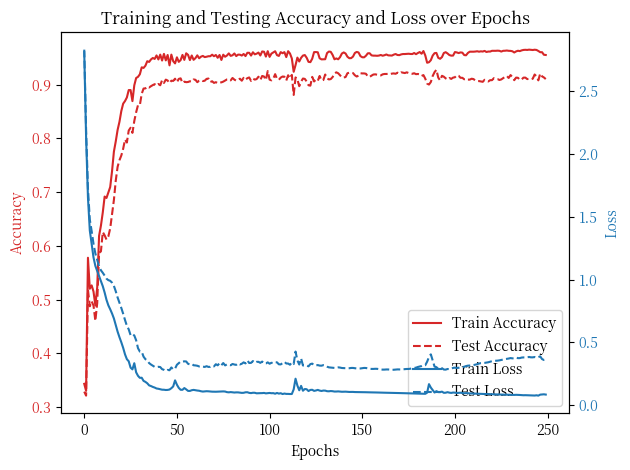

final train, test acc : 0.9552502632141113, 0.910417377948761
final train, test loss: 0.08484994620084763, 0.36182495951652527


In [5]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

plt.rcParams['font.family'] = 'Noto Serif SC'
plt.rcParams['font.sans-serif'] = ['Noto Serif SC']

color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(range(epochs), acc, color=color, label='Train Accuracy', linestyle='-')
ax1.plot(range(epochs), tacc, color=color, label='Test Accuracy', linestyle='--')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Loss', color=color)  
ax2.plot(range(epochs), loss, color=color, label='Train Loss', linestyle='-')
ax2.plot(range(epochs), tloss, color=color, label='Test Loss', linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc='lower right')

plt.title('Training and Testing Accuracy and Loss over Epochs')
fig.tight_layout()
# plt.savefig('./assets/gru.png')
plt.show()

print(f'final train, test acc : {acc[-1]}, {tacc[-1]}')
print(f'final train, test loss: {loss[-1]}, {tloss[-1]}')